In [30]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

## Load adata

In [ ]:
mtx = sc.read_mtx('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/mtx/GSE236581_counts.mtx.gz')
mtx = mtx.T

In [20]:
feature = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/mtx/GSE236581_features.tsv.gz', sep='\t', header=None)
feature.columns = ['Gene', 'Gene2', 'Feature']
feature.drop('Gene2', axis=1, inplace=True)

cell = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/mtx/GSE236581_barcodes.tsv.gz', sep='\t', header=None)
cell.columns = ['Identifier']

In [36]:
mtx.var_names = feature.Gene.values
mtx.obs_names = cell.Identifier.values

In [19]:
metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/GSE236581_CRC-ICB_metadata.txt.gz', sep=' ')

dict_Identifier_to_CellInfo = { tup.Index : [tup.Ident, tup.Patient, tup.Treatment, tup.Tissue, tup.MajorCellType, tup.SubCellType] for tup in metadata.itertuples() }

In [55]:
mtx.obs['SampleIdent']      = [ dict_Identifier_to_CellInfo[idx][0] for idx in mtx.obs.index ]
mtx.obs['Patient']          = [ dict_Identifier_to_CellInfo[idx][1] for idx in mtx.obs.index ]
mtx.obs['Treatment']        = [ dict_Identifier_to_CellInfo[idx][2] for idx in mtx.obs.index ]
mtx.obs['Tissue']           = [ dict_Identifier_to_CellInfo[idx][3] for idx in mtx.obs.index ]
mtx.obs['MajorCellType']    = [ dict_Identifier_to_CellInfo[idx][4] for idx in mtx.obs.index ]
mtx.obs['SubCellType']      = [ dict_Identifier_to_CellInfo[idx][5] for idx in mtx.obs.index ]

In [58]:
mtx.write('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/Author.raw.h5ad')

## Preprocess adata

In [3]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/Author.raw.h5ad')

In [9]:
adata_C = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')
adata_C.obs.head(2)

,doublet_score,predicted_doublet,SampleID,PatientID,BiopsySite,Accession,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,...,AvgSTRDiff,StdSTRDiff,NumSTRLoci,MSI,Response,Manual_CellType_lvl_1,MSI_score,MSI_score_z,Manual_CellType_lvl_2,Manual_CellType_lvl_3
AAACCTGAGAATTCCC-1,0.013780,False,P04-N-I,P04,Normal,HRR1372976,1197,7.088409,2594.0,7.861342,...,0.0,0.0,0,MSI,CR,T,-0.0,-0.280267,CD8+ T,CD8+ T
AAACCTGAGCTAGGCA-1,0.021638,False,P04-N-I,P04,Normal,HRR1372976,1206,7.095893,3195.0,8.069655,...,0.0,0.0,0,MSI,CR,B,-0.0,-0.280267,Naive B,Naive B


In [17]:
import numpy as np
d = dict()
for PatientID, edf in adata_C.obs[(adata_C.obs['Manual_CellType_lvl_3']=='Tumor cell')].groupby('PatientID'):
    d[PatientID] =np.mean(edf['MSI_score'])

d = dict(sorted(d.items(), key=lambda x:x[1]))
for e in list(d.keys()):
    print(e, end=', ')
list(d.keys())

P18, P17, P26, P15, P20, P19, P22, P23, P21, P04, 

/tmp/ipykernel_194538/2308328441.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_C.obs[(adata_C.obs['Manual_CellType_lvl_3']=='Tumor cell')].groupby('PatientID'):


['P18', 'P17', 'P26', 'P15', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

In [4]:
adata.raw = adata

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
# sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="SampleIdent")
# sc.tl.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

## Visualize Tex abundance: MSI-H vs. MSI-I vs. MSI-L

In [21]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P26', 'P15', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
metadata_MSI = metadata[(metadata['Patient'].isin(chen_patient_order_by_MSI_intensity))].copy()

In [22]:
dict_AuthorCellType_to_lvl_1b_CellType = {
    'c01_CD4_Tn_CCR7' : 'CD4+ T',
    'c02_CD4_Tn_SELL' : 'CD4+ T',
    'c03_CD4_Tn_NR4A2' : 'CD4+ T',
    'c04_CD4_Tcm_ANXA1' : 'CD4+ T',
    'c05_CD4_Tcm_GPR183' : 'CD4+ T',
    'c06_CD4_Trm_HSPA1A' : 'CD4+ T',
    'c07_CD4_Th17_CTSH' : 'CD4+ T',
    'c08_CD4_Tfh_CXCL13_IL6ST' : 'CD4+ T',
    'c09_CD4_Th1_CXCL13_HAVCR2' : 'CD4+ T',
    'c10_CD4_Temra_GZMB' : 'CD4+ T',
    'c11_CD4_Treg_FOXP3' : 'CD4+ T',
    'c12_CD4_Treg_KLRB1' : 'CD4+ T',
    'c13_CD4_Treg_TNFRSF9' : 'CD4+ T',
    'c14_CD4_MT' : 'CD4+ T',
    'c15_CD8_Tn_CCR7' : 'CD8+ T',
    'c16_CD8_Tn_SELL' : 'CD8+ T',
    'c17_CD8_Tcm_GPR183' : 'CD8+ T',
    'c18_CD8_Tcm_ANXA1' : 'CD8+ T',
    'c19_CD8_Tem_CMC1' : 'CD8+ T',
    'c20_CD8_Tem_GZMK' : 'CD8+ T',
    'c21_CD8_Trm_XCL1' : 'CD8+ T',
    'c22_CD8_Trm_HSPA1B' : 'CD8+ T',
    'c23_CD8_Tex_LAYN' : 'CD8+ T',
    'c24_CD8_Temra_CX3CR1' : 'CD8+ T',
    'c25_CD8_Temra_TYROBP' : 'CD8+ T',
    'c26_CD8_MAIT_KLRB1' : 'N/A',   #! Low cell count
    'c27_CD8_MAIT_SLC4A10' : 'CD8+ T',
    'c28_CD8_IEL_CD160' : 'CD8+ T',
    'c29_T_MKI67' : 'T',
    'c30_gdT_TRDV2' : 'gd T',
    'c31_DNT' : 'T',
    'c32_DPT' : 'N/A',
    'c33_ILC_GZMK' : 'ILC',
    'c34_ILC_NR4A2' : 'ILC',
    'c35_ILC_FCGR3A' : 'N/A',   #! Low cell count   
    'c36_ILC_SYNE2' : 'N/A',    #! Low cell count
    'c37_ILC_SLC4A10' : 'ILC',
    'c38_ILC_MKI67' : 'ILC',
    'c39_NaiveB_TCL1A' : 'B',
    'c40_NaiveB_IGHD' : 'B',
    'c41_MemB_CD27' : 'B',
    'c42_MemB_GPR183' : 'B',
    'c43_GCB_LRMP' : 'B',
    'c44_GCB_MKI67' : 'B',
    'c45_PlasmaB_TXNDC5' : 'Plasma',
    'c46_PlasmaB_IGHA1' : 'Plasma',
    'c47_PlasmaB_IGHG1' : 'Plasma',
    'c48_PlasmaB_MKI67' : 'Plasma',
    'c49_Mono_CD14' : 'Monocyte',
    'c50_Mono_FCGR3A' : 'N/A',  #! Low cell count
    'c51_Mono_NFKBIZ' : 'N/A',  #! Low cell count
    'c52_Mast_TPSAB1' : 'Mast',
    'c53_Neu_CXCR2' : 'Neutrophil',
    'c54_pDC_LILRA4' : 'N/A',   #! Low cell count
    'c55_pDC_GZMB' : 'DC',
    'c56_tDC_SIGLEC6' : 'N/A',  #! Low cell count
    'c57_cDC_CLEC9A' : 'DC',
    'c58_cDC_CD1C' : 'N/A',     #! Low cell count
    'c59_cDC_IL1B' : 'DC',
    'c60_cDC_LAMP3' : 'DC',
    'c61_Mph_FCGR3A' : 'Macrophage',
    'c62_Mph_S100A8' : 'Macrophage',
    'c63_Mph_CCL20' : 'Macrophage',
    'c64_Mph_SPP1' : 'Macrophage',
    'c65_Mph_APOE' : 'Macrophage',
    'c66_Endo_LYVE1' : 'N/A',   #! Low cell count
    'c67_Endo_ACKR1' : 'Endothelial',
    'c68_Endo_FABP5' : 'Endothelial',
    'c69_Endo_CXCL12' : 'Endothelial',
    'c70_Endo_COL4A1' : 'Endothelial',
    'c71_Endo_MKI67' : 'Endothelial',
    'c72_Fibro_SOX6' : 'Fibroblast',
    'c73_Fibro_ADAMDEC1' : 'Fibroblast',
    'c74_Fibro_C7' : 'Fibroblast',
    'c75_Fibro_CCL19' : 'Fibroblast',
    'c76_Fibro_PI16' : 'N/A',   #! Low cell count
    'c77_Fibro_ACTA2' : 'Fibroblast',
    'c78_Fibro_DES' : 'N/A',    #! Low cell count
    'c79_Fibro_FAP' : 'Fibroblast',
    'c80_Fibro_MKI67' : 'Fibroblast',
    'c81_Pericyte_RGS5' : 'Pericyte',
    'c82_SMC_MYH11' : 'SMC',
    'c83_Glia_PLP1' : 'Glial',
    'c84_Coloncyte_CA2' : 'Enterocyte',
    'c85_Coloncyte_SLC26A3' : 'Enterocyte',
    'c86_Coloncyte_BEST4' : 'Enterocyte',
    'c87_Goblet_MUC2' : 'Goblet',
    'c88_EEC_PCSK1N' : 'Enteroendocrine',
    'c89_Tuft_PTGS1' : 'Tuft',
    'c90_Epi_MKI67' : 'Intestinal stem',
    'c91_Epi_Tumor' : 'Intestinal stem',
}

dict_AuthorCellType_to_lvl_2b_CellType = {
    
    'c01_CD4_Tn_CCR7' : 'CD4+ Tn',
    'c02_CD4_Tn_SELL' : 'CD4+ Tn',
    'c03_CD4_Tn_NR4A2' : 'CD4+ Tn',
    'c04_CD4_Tcm_ANXA1' : 'CD4+ Tcm',   # Central memory
    'c05_CD4_Tcm_GPR183' : 'CD4+ Tcm',  # Central memory
    'c06_CD4_Trm_HSPA1A' : 'CD4+ Trm',  # Tissue-resident memory 
    'c07_CD4_Th17_CTSH' : 'CD4+ Th17',  # Helper 17
    'c08_CD4_Tfh_CXCL13_IL6ST' : 'CD4+ Tfh', # Follicular helper
    'c09_CD4_Th1_CXCL13_HAVCR2' : 'CD4+ Th1',
    'c10_CD4_Temra_GZMB' : 'CD4+ Temra', # Effective memory re-expressing CD45RA
    'c11_CD4_Treg_FOXP3' : 'CD4+ Treg',
    'c12_CD4_Treg_KLRB1' : 'CD4+ Treg',
    'c13_CD4_Treg_TNFRSF9' : 'CD4+ Treg',
    'c14_CD4_MT' : 'CD4+ Tm',   # Memory T?
    
    'c15_CD8_Tn_CCR7' : 'CD8+ Tn',
    'c16_CD8_Tn_SELL' : 'CD8+ Tn',
    'c17_CD8_Tcm_GPR183' : 'CD8+ Tcm',
    'c18_CD8_Tcm_ANXA1' : 'CD8+ Tcm',
    'c19_CD8_Tem_CMC1' : 'CD8+ Tem',
    'c20_CD8_Tem_GZMK' : 'CD8+ Tcm',
    'c21_CD8_Trm_XCL1' : 'CD8+ Trm',
    'c22_CD8_Trm_HSPA1B' : 'CD8+ Trm',
    'c23_CD8_Tex_LAYN' : 'CD8+ Tex',
    'c24_CD8_Temra_CX3CR1' : 'CD8+ Temra',
    'c25_CD8_Temra_TYROBP' : 'CD8+ Temra',
    'c26_CD8_MAIT_KLRB1' : 'N/A',     #! Low cell count
    'c27_CD8_MAIT_SLC4A10' : 'CD8+ MAIT',
    'c28_CD8_IEL_CD160' : 'CD8+ IEL',
    'c29_T_MKI67' : 'CD8+ Proliferating T',
    'c30_gdT_TRDV2' : 'γδ2+ T',
    'c31_DNT' : 'CD4-CD8- T',
    'c32_DPT' : 'N/A',
    
    'c33_ILC_GZMK' : 'ILC',
    'c34_ILC_NR4A2' : 'ILC',
    'c35_ILC_FCGR3A' : 'N/A',   #! Low cell count
    'c36_ILC_SYNE2' : 'N/A',    #! Low cell count
    'c37_ILC_SLC4A10' : 'ILC',
    'c38_ILC_MKI67' : 'ILC',
    
    'c39_NaiveB_TCL1A' : 'Naive B',
    'c40_NaiveB_IGHD' : 'Naive B',
    'c41_MemB_CD27' : 'Memory B',
    'c42_MemB_GPR183' : 'Memory B',
    'c43_GCB_LRMP' : 'GC B',
    'c44_GCB_MKI67' : 'GC B',
    'c45_PlasmaB_TXNDC5' : 'IGHA+ Plasma',  #! Confirmed IGHA expression
    'c46_PlasmaB_IGHA1' : 'IGHA+ Plasma',   #! Confirmed IGHA expression
    'c47_PlasmaB_IGHG1' : 'IGHG+ Plasma',
    'c48_PlasmaB_MKI67' : 'IGHA+ Plasma',
    
    'c49_Mono_CD14' : 'Monocyte',
    'c50_Mono_FCGR3A' : 'N/A',  #! Low cell count
    'c51_Mono_NFKBIZ' : 'N/A',  #! Low cell count
    'c52_Mast_TPSAB1' : 'Mast',
    'c53_Neu_CXCR2' : 'Neutrophil',
    'c54_pDC_LILRA4' : 'N/A',   #! Low cell count
    'c55_pDC_GZMB' : 'pDC',
    'c56_tDC_SIGLEC6' : 'N/A',  #! Low cell count
    'c57_cDC_CLEC9A' : 'cDC',
    'c58_cDC_CD1C' : 'N/A',     #! Low cell count
    'c59_cDC_IL1B' : 'cDC',
    'c60_cDC_LAMP3' : 'cDC',
    
    'c61_Mph_FCGR3A' : 'Macrophage',
    'c62_Mph_S100A8' : 'Macrophage',
    'c63_Mph_CCL20' : 'Macrophage',
    'c64_Mph_SPP1' : 'Macrophage',
    'c65_Mph_APOE' : 'Macrophage',
    
    'c66_Endo_LYVE1' : 'N/A',   #! Low cell count
    'c67_Endo_ACKR1' : 'Endothelial',
    'c68_Endo_FABP5' : 'Endothelial',
    'c69_Endo_CXCL12' : 'Endothelial',
    'c70_Endo_COL4A1' : 'Endothelial',
    'c71_Endo_MKI67' : 'Endothelial',
    
    'c72_Fibro_SOX6' : 'Fibroblast',
    'c73_Fibro_ADAMDEC1' : 'Fibroblast',
    'c74_Fibro_C7' : 'Fibroblast',
    'c75_Fibro_CCL19' : 'Fibroblast',
    'c76_Fibro_PI16' : 'N/A',   #! Low cell count
    'c77_Fibro_ACTA2' : 'Fibroblast',
    'c78_Fibro_DES' : 'N/A',    #! Low cell count
    'c79_Fibro_FAP' : 'Fibroblast',
    'c80_Fibro_MKI67' : 'Fibroblast',
    'c81_Pericyte_RGS5' : 'Pericyte',
    'c82_SMC_MYH11' : 'SMC',
    'c83_Glia_PLP1' : 'Glial',
    
    'c84_Coloncyte_CA2' : 'Enterocyte',
    'c85_Coloncyte_SLC26A3' : 'Enterocyte',
    'c86_Coloncyte_BEST4' : 'Enterocyte',
    'c87_Goblet_MUC2' : 'Goblet',
    'c88_EEC_PCSK1N' : 'Enteroendocrine',
    'c89_Tuft_PTGS1' : 'Tuft',
    'c90_Epi_MKI67' : 'Intestinal stem',
    'c91_Epi_Tumor' : 'Intestinal stem',
}

dict_PatientID_to_MSI_class = {'SC044': 'MSI-H',
                                'CRC2783': 'MSI-I',
                                'SC035': 'MSI-I',
                                'CRC2817': 'MSI-L',


                                'P04': 'MSI-H',
                                'P21': 'MSI-H',
                                'P23': 'MSI-H',
                                
                                'P15': 'MSI-I',
                                'P19': 'MSI-I',
                                'P20': 'MSI-I',
                                'P22': 'MSI-I',
                                'P26': 'MSI-I',
                                
                                'P17': 'MSI-L',
                                'P18': 'MSI-L'}

metadata_MSI['Author_CellType_lvl_1b'] = [ dict_AuthorCellType_to_lvl_1b_CellType[AuthorCellType] for AuthorCellType in metadata_MSI['SubCellType'] ]
metadata_MSI['Author_CellType_lvl_2b'] = [ dict_AuthorCellType_to_lvl_2b_CellType[AuthorCellType] for AuthorCellType in metadata_MSI['SubCellType'] ]
metadata_MSI['MSI_class'] = [ dict_PatientID_to_MSI_class[PatientID] for PatientID in metadata_MSI['Patient'] ]
metadata_MSI.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,Ident,Patient,Treatment,Tissue,MajorCellType,SubCellType,Author_CellType_lvl_1b,Author_CellType_lvl_2b,MSI_class
CRC04-N-I_AAACGGGAGCCAGAAC,SeuratProject,1991,628,CRC04-N-I,P04,I,Normal,Epi,c85_Coloncyte_SLC26A3,Enterocyte,Enterocyte,MSI-H
CRC04-N-I_AAACGGGCAAAGTGCG,SeuratProject,7529,2484,CRC04-N-I,P04,I,Normal,Epi,c84_Coloncyte_CA2,Enterocyte,Enterocyte,MSI-H


In [23]:
metadata2 = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.run_meta.organized.tsv', sep='\t')
metadata2['Ident'] = [ tup.SampleID.replace('P', 'CRC') for tup in metadata2.itertuples() ]
dict_Ident_to_TreatmentInfo = { Ident : edf['TreatmentStage'].iloc[0] for Ident, edf in metadata2.groupby('Ident', observed=True) }

metadata_MSI['TreatmentStage'] = [ dict_Ident_to_TreatmentInfo[Ident] for Ident in metadata_MSI['Ident'] ]
metadata_MSI

,orig.ident,nCount_RNA,nFeature_RNA,Ident,Patient,Treatment,Tissue,MajorCellType,SubCellType,Author_CellType_lvl_1b,Author_CellType_lvl_2b,MSI_class,TreatmentStage
CRC04-N-I_AAACGGGAGCCAGAAC,SeuratProject,1991,628,CRC04-N-I,P04,I,Normal,Epi,c85_Coloncyte_SLC26A3,Enterocyte,Enterocyte,MSI-H,Pre
CRC04-N-I_AAACGGGCAAAGTGCG,SeuratProject,7529,2484,CRC04-N-I,P04,I,Normal,Epi,c84_Coloncyte_CA2,Enterocyte,Enterocyte,MSI-H,Pre
CRC04-N-I_AAAGATGGTGGTAACG,SeuratProject,1839,692,CRC04-N-I,P04,I,Normal,Epi,c87_Goblet_MUC2,Goblet,Goblet,MSI-H,Pre
CRC04-N-I_AAAGCAATCTGCTTGC,SeuratProject,1320,672,CRC04-N-I,P04,I,Normal,Epi,c84_Coloncyte_CA2,Enterocyte,Enterocyte,MSI-H,Pre
CRC04-N-I_AAATGCCAGCGATAGC,SeuratProject,3594,1029,CRC04-N-I,P04,I,Normal,Epi,c84_Coloncyte_CA2,Enterocyte,Enterocyte,MSI-H,Pre
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CRC23-T-IV_TCGTAGAGTTGATTCG,SeuratProject,2481,1149,CRC23-T-IV,P23,IV,Tumor,ILC,c34_ILC_NR4A2,ILC,ILC,MSI-H,Post
CRC23-T-IV_TGCCAAATCCGCATAA,SeuratProject,2569,1232,CRC23-T-IV,P23,IV,Tumor,ILC,c34_ILC_NR4A2,ILC,ILC,MSI-H,Post
CRC23-T-IV_TGCGGGTGTCCAGTTA,SeuratProject,4096,1306,CRC23-T-IV,P23,IV,Tumor,ILC,c34_ILC_NR4A2,ILC,ILC,MSI-H,Post
CRC23-T-IV_TTGACTTCATGTTGAC,SeuratProject,1994,902,CRC23-T-IV,P23,IV,Tumor,ILC,c34_ILC_NR4A2,ILC,ILC,MSI-H,Post


In [108]:
set(metadata_MSI['TreatmentStage'])

{'On', 'Post', 'Pre'}

In [24]:
CellTypeDynamics = list()

for Patient, edf in metadata_MSI[(metadata_MSI['Tissue']=='Tumor') & (metadata_MSI['MajorCellType']!='Epi')].groupby('Patient', observed=True):
    dict_TreatmentStage_to_TotalCount = { TreatmentStage : len(edf2) for TreatmentStage, edf2 in edf.groupby('TreatmentStage', observed=True) }

    for Author_CellType_lvl_2b, edf2 in edf.groupby('Author_CellType_lvl_2b'):
        dict_TreatmentStage_to_Proportion = { TreatmentStage : len(edf3)/dict_TreatmentStage_to_TotalCount[TreatmentStage] for TreatmentStage, edf3 in edf2.groupby('TreatmentStage', observed=True) }
        for ts in {'On', 'Post', 'Pre'}:
            try: dict_TreatmentStage_to_Proportion[ts]
            except KeyError: dict_TreatmentStage_to_Proportion[ts] = 0
        
        # CellTypeDynamics.append( [Patient, Author_CellType_lvl_2b, dict_TreatmentStage_to_Proportion['Pre'], dict_TreatmentStage_to_Proportion['On'], dict_TreatmentStage_to_Proportion['Post']] )
        CellTypeDynamics.append( [Patient, Author_CellType_lvl_2b, 'Pre', dict_TreatmentStage_to_Proportion['Pre'],] )
        CellTypeDynamics.append( [Patient, Author_CellType_lvl_2b, 'On', dict_TreatmentStage_to_Proportion['On'],] )
        CellTypeDynamics.append( [Patient, Author_CellType_lvl_2b, 'Post', dict_TreatmentStage_to_Proportion['Post'],] )

try:
    CellTypeDynamics = pd.DataFrame(CellTypeDynamics, columns=['PatientID', 'CellType', 'Pre', 'On', 'Post'])
except:
    CellTypeDynamics = pd.DataFrame(CellTypeDynamics, columns=['PatientID', 'CellType', 'TreatmentStage', 'Proportion'])

CellTypeDynamics['MSI_class'] = [ dict_PatientID_to_MSI_class[PatientID] for PatientID in CellTypeDynamics['PatientID'] ]
dict_PatientID_to_Response = { tup.PatientID : tup.Response for tup in metadata2.itertuples()  }
CellTypeDynamics['Response'] = [ dict_PatientID_to_Response[PatientID] for PatientID in CellTypeDynamics['PatientID'] ]

In [25]:
CellTypeDynamics

,PatientID,CellType,TreatmentStage,Proportion,MSI_class,Response
0,P04,CD4+ Tcm,Pre,0.073208,MSI-H,CR
1,P04,CD4+ Tcm,On,0.073981,MSI-H,CR
2,P04,CD4+ Tcm,Post,0.044162,MSI-H,CR
3,P04,CD4+ Temra,Pre,0.000383,MSI-H,CR
4,P04,CD4+ Temra,On,0.000000,MSI-H,CR
...,...,...,...,...,...,...
1105,P26,pDC,On,0.000000,MSI-I,CR
1106,P26,pDC,Post,0.000634,MSI-I,CR
1107,P26,γδ2+ T,Pre,0.002085,MSI-I,CR
1108,P26,γδ2+ T,On,0.000000,MSI-I,CR


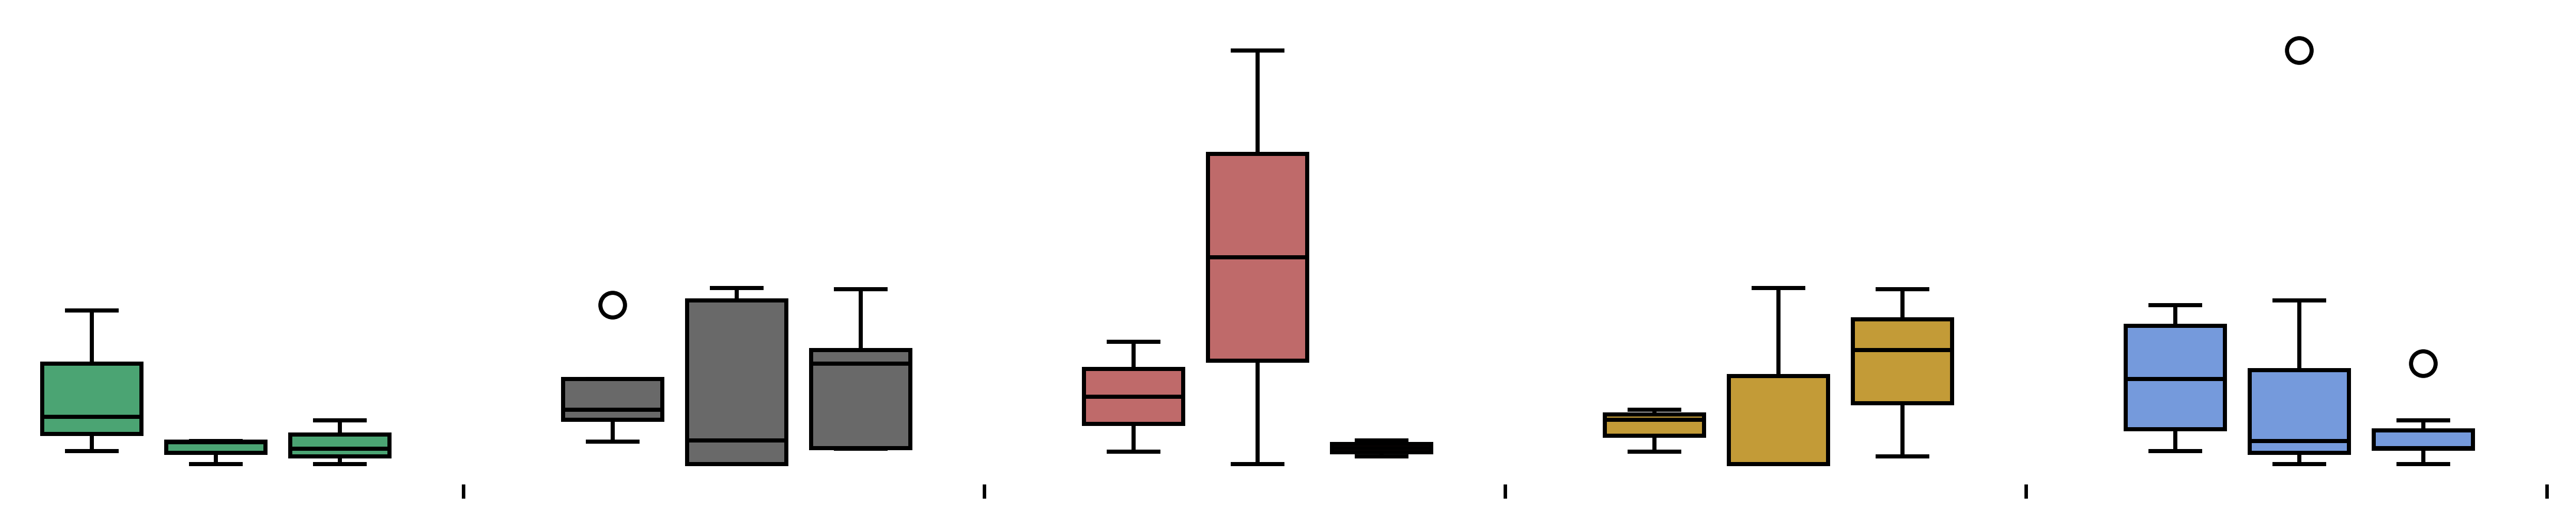

In [29]:
fig, axes = plt.subplots(1, 5, figsize=(11, 2), sharex=True, sharey=True, dpi=500)

dict_MSI_class_to_axesIdx = {
    'MSI-L' : 2,
    'MSI-I' : 1,
    'MSI-H' : 0,
}

dict_MSI_class_to_color = {
    'MSI-L' : 'indianred',
    'MSI-I' : 'dimgray',
    'MSI-H' : 'mediumseagreen',
}

dict_Response_to_axesIdx = {
    'PR' : 3,
    'CR' : 4,
}
dict_Response_to_color = {
    'PR' : 'goldenrod',
    'CR' : 'cornflowerblue',
}
CellType_oi = [ CT for CT in set(CellTypeDynamics['CellType']) if 'CD8+ Tex' in CT ]

for MSI_class, edf in CellTypeDynamics[(CellTypeDynamics['CellType'].isin(CellType_oi)) & 
                                       (CellTypeDynamics['PatientID']!='P1a8')].groupby('MSI_class', observed=True):
    ax = sns.boxplot(data=edf, x='TreatmentStage', y='Proportion', 
                     color=dict_MSI_class_to_color[MSI_class], ax=axes[dict_MSI_class_to_axesIdx[MSI_class]],
                     linecolor='black',
                     )
    
    # for PatientID, edf2 in edf.groupby('PatientID', observed=True):
    #     ax = sns.lineplot(data=edf2, x='TreatmentStage', y='Proportion', 
    #                  # color=dict_MSI_class_to_color[MSI_class], 
    #                  color='black',
    #                  ax=axes[dict_MSI_class_to_axesIdx[MSI_class]]
    #                  # order=['Pre', 'On', 'Post']
    #                  )
    
    ax.set_xlabel('');
    ax.set_xticklabels([]);
    ax.set_xticks(['', '', '']);
    ax.set_ylabel('');
    ax.set_yticklabels([]);
    ax.set_yticks([]);
    
    # sns.lineplot(data=edf, x='TreatmentStage', y='Proportion', color='black', ax=axes[dict_MSI_class_to_axesIdx[MSI_class]], alpha=1,)
    sns.despine(left=True, bottom=True)
    
for Response, edf in CellTypeDynamics[(CellTypeDynamics['CellType'].isin(CellType_oi)) & 
                                       (CellTypeDynamics['PatientID']!='P1a8')].groupby('Response', observed=True):
    ax = sns.boxplot(data=edf, x='TreatmentStage', y='Proportion', color=dict_Response_to_color[Response], ax=axes[dict_Response_to_axesIdx[Response]],
                     linecolor='black',
                     )


    ax.set_xlabel('');
    ax.set_xticklabels([]);
    ax.set_xticks(['', '']);
    ax.set_ylabel('');
    ax.set_yticklabels([]);
    ax.set_yticks([]);
    
    sns.despine(left=True, bottom=True)

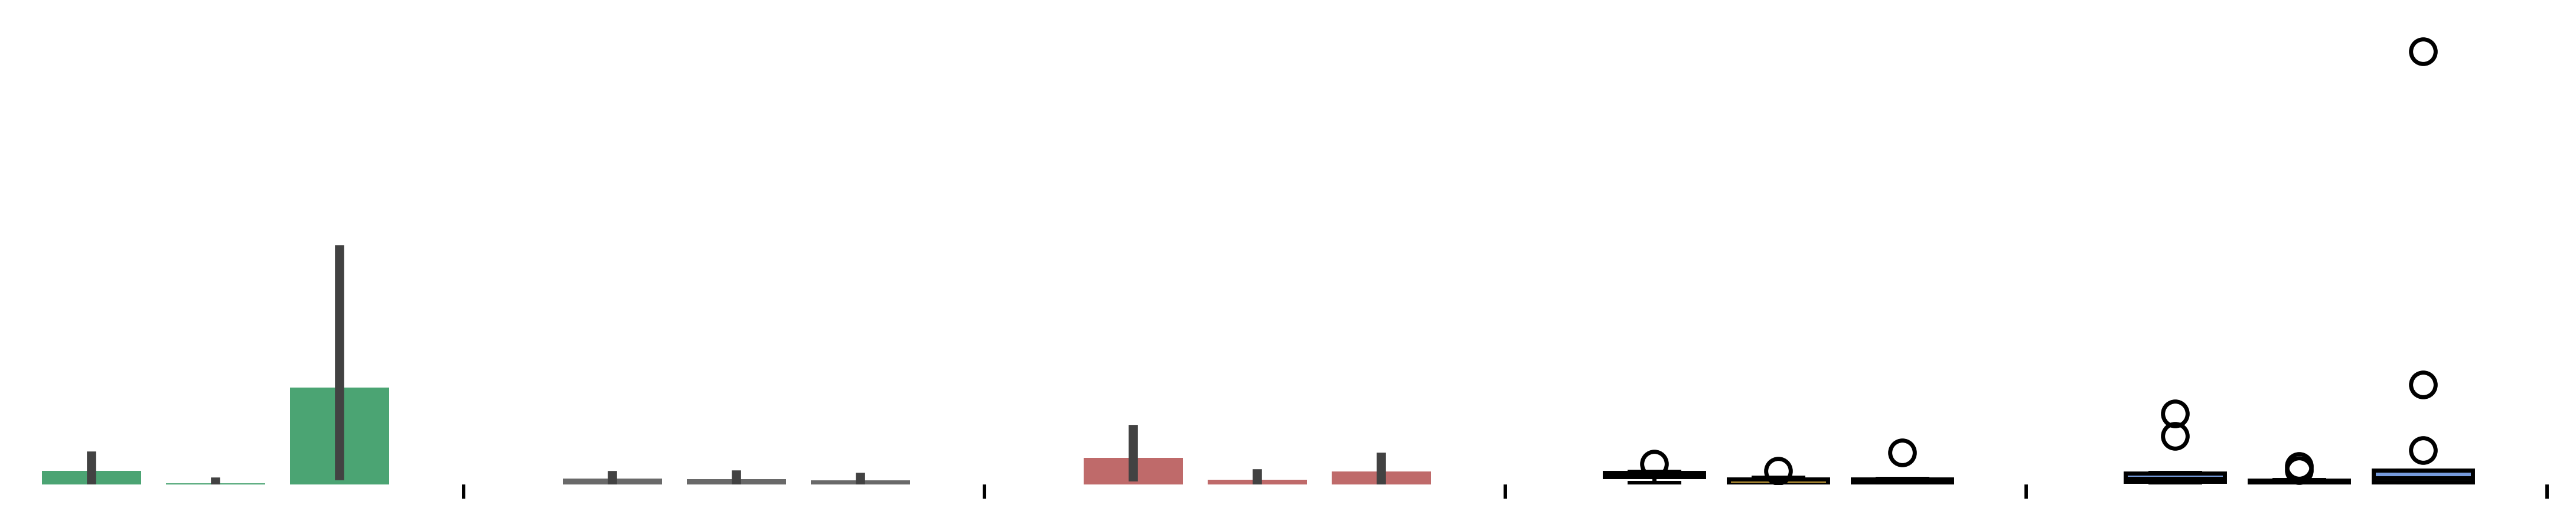

In [35]:
fig, axes = plt.subplots(1, 5, figsize=(11, 2), sharex=True, sharey=True, dpi=500)

dict_MSI_class_to_axesIdx = {
    'MSI-L' : 2,
    'MSI-I' : 1,
    'MSI-H' : 0,
}

dict_MSI_class_to_color = {
    'MSI-L' : 'indianred',
    'MSI-I' : 'dimgray',
    'MSI-H' : 'mediumseagreen',
}

dict_Response_to_axesIdx = {
    'PR' : 3,
    'CR' : 4,
}
dict_Response_to_color = {
    'PR' : 'goldenrod',
    'CR' : 'cornflowerblue',
}
CellType_oi = [ CT for CT in set(CellTypeDynamics['CellType']) if 'CD8+ Tem' in CT ]

for MSI_class, edf in CellTypeDynamics[(CellTypeDynamics['CellType'].isin(CellType_oi)) & 
                                       (CellTypeDynamics['PatientID']!='P1a8')].groupby('MSI_class', observed=True):
    ax = sns.boxplot(data=edf, x='TreatmentStage', y='Proportion', 
                     color=dict_MSI_class_to_color[MSI_class], ax=axes[dict_MSI_class_to_axesIdx[MSI_class]],
                     linecolor='black',
                     )
    
    # for PatientID, edf2 in edf.groupby('PatientID', observed=True):
    #     ax = sns.lineplot(data=edf2, x='TreatmentStage', y='Proportion', 
    #                  # color=dict_MSI_class_to_color[MSI_class], 
    #                  color='black',
    #                  ax=axes[dict_MSI_class_to_axesIdx[MSI_class]]
    #                  # order=['Pre', 'On', 'Post']
    #                  )
    
    ax.set_xlabel('');
    ax.set_xticklabels([]);
    ax.set_xticks(['', '', '']);
    ax.set_ylabel('');
    ax.set_yticklabels([]);
    ax.set_yticks([]);
    
    # sns.lineplot(data=edf, x='TreatmentStage', y='Proportion', color='black', ax=axes[dict_MSI_class_to_axesIdx[MSI_class]], alpha=1,)
    sns.despine(left=True, bottom=True)
    
for Response, edf in CellTypeDynamics[(CellTypeDynamics['CellType'].isin(CellType_oi)) & 
                                       (CellTypeDynamics['PatientID']!='P1a8')].groupby('Response', observed=True):
    ax = sns.boxplot(data=edf, x='TreatmentStage', y='Proportion', color=dict_Response_to_color[Response], ax=axes[dict_Response_to_axesIdx[Response]],
                     linecolor='black',
                     )


    ax.set_xlabel('');
    ax.set_xticklabels([]);
    ax.set_xticks(['', '']);
    ax.set_ylabel('');
    ax.set_yticklabels([]);
    ax.set_yticks([]);
    
    sns.despine(left=True, bottom=True)

## T-cell DEGs 

In [38]:
adata_MSI = adata[adata.obs['Patient'].isin( list(dict_PatientID_to_MSI_class.keys()) )].copy()

In [39]:
adata_MSI.obs['Author_CellType_lvl_1b'] = [ dict_AuthorCellType_to_lvl_1b_CellType[SCT] for SCT in adata_MSI.obs['SubCellType'] ]
adata_MSI.obs['Author_CellType_lvl_2b'] = [ dict_AuthorCellType_to_lvl_2b_CellType[SCT] for SCT in adata_MSI.obs['SubCellType'] ]
adata_MSI.obs['MSI_class']              = [ dict_PatientID_to_MSI_class[PatientID] for PatientID in adata_MSI.obs['Patient'] ]
adata_MSI.obs['TreatmentStage']         = [ dict_Ident_to_TreatmentInfo[SampleIdent] for SampleIdent in adata_MSI.obs['SampleIdent'] ]
adata_MSI.obs['Response']               = [dict_PatientID_to_Response[PatientID] for PatientID in adata_MSI.obs['Patient'] ]

In [56]:
sc.pl.dotplot(adata_MSI[(adata_MSI.obs['TreatmentStage']=='On') & 
                        (adata_MSI.obs['Tissue']=='Tumor') & 
                        (adata_MSI.obs['Author_CellType_lvl_1b']=='CD8+ T')], 
              var_names=['GZMA', 'GZMB', 'GZMK', 'GZMH', 'IFNG', 'PRF1'], 
            #   standard_scale='var',
              groupby='Patient',
              categories_order=['P18', 'P20', 'P19', 'P22', 'P23', 'P04'], 
              swap_axes=True,
              use_raw=False,
              )

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying

ERROR: Please check that the categories given by the `order` parameter match the categories that want to be reordered.

Mismatch: {'P17', 'P26', 'P21', 'P15'}

Given order categories: ['P18', 'P20', 'P19', 'P22', 'P23', 'P04']

Patient categories: ['P04', 'P15', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P26']



AttributeError: 'DotPlot' object has no attribute 'group_extra_size'

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


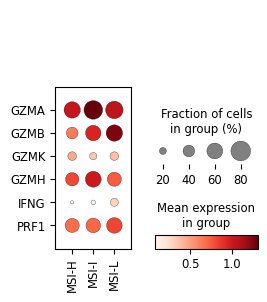

In [376]:
sc.pl.dotplot(adata_MSI[(adata_MSI.obs['TreatmentStage']=='On') & (adata_MSI.obs['Author_CellType_lvl_1b']=='CD8+ T')], 
              var_names=['GZMA', 'GZMB', 'GZMK', 'GZMH', 'IFNG', 'PRF1'], 
            #   standard_scale='var',
              groupby='MSI_class', 
              swap_axes=True,
              use_raw=False,
              )

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying

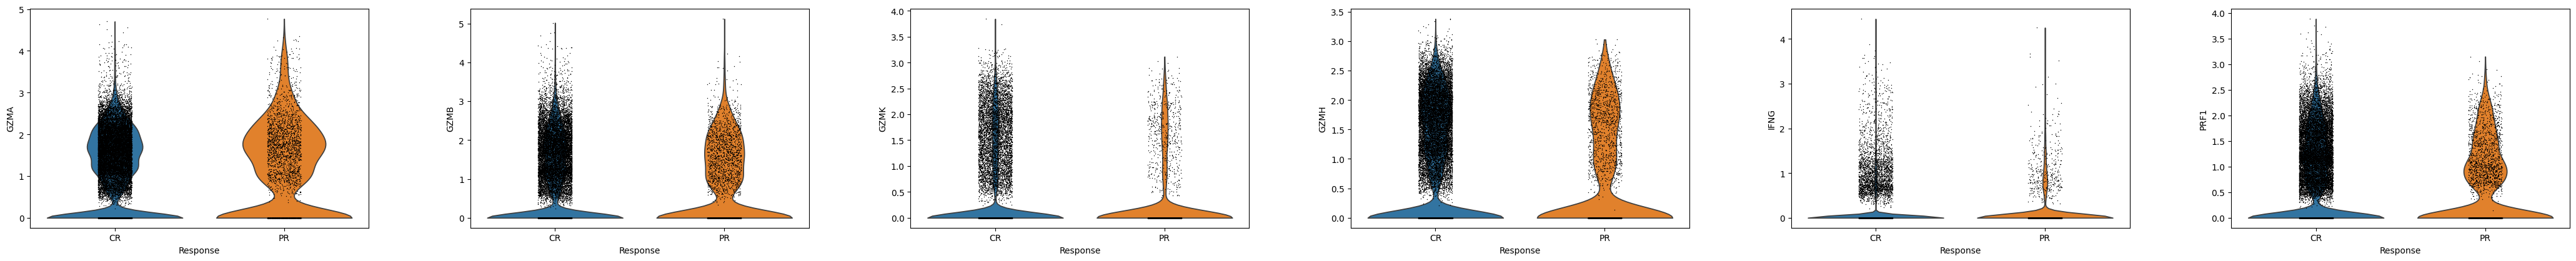

In [381]:
sc.pl.violin(adata_MSI[(adata_MSI.obs['TreatmentStage']=='On') & (adata_MSI.obs['Author_CellType_lvl_1b']=='CD8+ T')], 
              keys=['GZMA', 'GZMB', 'GZMK', 'GZMH', 'IFNG', 'PRF1'], 
            #   standard_scale='var',
              groupby='Response', 
              use_raw=False,
              )

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


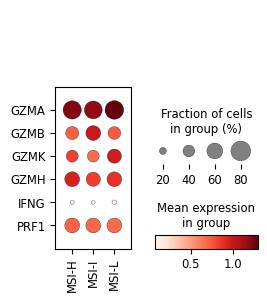

In [377]:
sc.pl.dotplot(adata_MSI[(adata_MSI.obs['TreatmentStage']=='Post') & (adata_MSI.obs['Author_CellType_lvl_1b']=='CD8+ T')], 
              var_names=['GZMA', 'GZMB', 'GZMK', 'GZMH', 'IFNG', 'PRF1'], 
            #   standard_scale='var',
              groupby='MSI_class', 
              swap_axes=True,
              use_raw=False,
              )